# Crustal Velocity to Density Conversion

This notebook outlines how to use the velocity-to curstal density conversion scheme described in Stephenson et al. (2023).  It provides some example profiles to show the uses and limitations of the approach.

### Background

This density conversion scheme is based upon an empirical pressure-dependent parametrisation that exploits a compilation of laboratory-determined velocity and density measurements compiled from the literature.  It can be used to convert velocity profiles into density as a function of pressure and temperature.

### Before Starting

Please ensure that the programs contained in the `SCRIPTS` directory are added to your `$PYTHONPATH`.  We do this manually in the first cell in this tutorial, but if that doesn't work then check that you have it in your local environment path.  This notebook requires access to these scripts and will not run without them.  Required programs are...

> * `density_functions.py`
> * `spatial_functions.py`
> * `coincident_profile_functions.py`
> * `uncertainties.py`
> * `temperature_dependence.py`

We will also make use of the `plotting.py` module within this directory.

External third party modules that neeed to be installed include...

> * `numpy`
> * `scipy`
> * `pandas`
> * `matplotlib`
> * `Cartopy`


First we will import the necessary packages...

In [1]:
import sys

# append SCRIPTS directory to pythonpath so that this notebook can find the relevant modules
# to be updated in future version so that package can be installed.
#sys.path.append('../SMV2rho/')
#print(f"my path: {sys.path}")

# import packages
# some standard packages
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from plotting import *

# packages for density conversion
from SMV2rho.density_functions import *      # density conversion package
from SMV2rho.spatial_functions import *      # functions to calculate distances between points
from SMV2rho.coincident_profile_functions import *    # functions to locate profiles in similar locations
from SMV2rho.plotting import *    # functions to locate profiles in similar locations


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### File layout

First let's take a look at the necessary file structure required by this family of programs.

The velocity profiles in the seisCRUST repository can be downloaded and used here.

The required file format is strict because the scripts will read the file in a particular order.  If the file is not presented in this format then errors will occur.  Please not that this requirements means that continuous 3-D models must first be converted into 1-D profiles before using the software.  Run the following cell to see the required file layout.  Note only ascii text files with the `.dat` suffix are acceptable.

First we will use a local file stored in the TEST_DATA directory with this release.

In [2]:
# path to test velocity file
vp_file = "../TEST_DATA/EUROPE/Vp/RECEIVER_FUNCTION/DATA/M19_AQU_Vp.dat"

print("\nExample file:\n \
       ID \n \
       lon lat \n \
       crustal_thickness \n \
       V  -depth \n \
       .   . \n \
       .   . \n \
       .   . \n")

# print the file format
print("Real file...\n")
print_text_file(vp_file)


Example file:
        ID 
        lon lat 
        crustal_thickness 
        V  -depth 
        .   . 
        .   . 
        .   . 

Real file...

M19_AQU_Vp
13.48	42.34
37.2
4.84865  0
4.84865  -2.5
7.23144  -2.5
7.23144  -16.2
6.42768  -16.2
6.42768  -37.2
6.55704  -37.2
6.55704  -65.9



### Data structure

The required data structure is equally strict.  In particular when multiple files are being converted in one run, then the file structure ensures that files can be opened, read, converted and saved in the correct places.

In general the structure follows the following format 

`V_PROFILES/VELOCITY_TYPE/REGION/METHOD/DATA`

You can run the following cell to see the structure of the `DATA` directory and how this general structure looks in reality.

NB.  We can include as many regions as we like, and as many methods as we like and these regions and methods can have any number of arbitrary names.  The density conversion programme will loop through all regions and methods adding them to dictionary keys that will be saved throughout to procedure.  These will then be used to save the calculated density (and sometimes velocity) files in the correct places.

In [3]:
# draw a file tree

draw_file_tree('../TEST_DATA', include_files=False, 
               suppress_pycache=True, suppress_hidden=True)

TEST_DATA
|- TEST_DATA
|  `- EUROPE
|     `- Vp
|        `- RECEIVER_FUNCTION
|           `- DATA


### Converting an individual profile

Let's now convert a profile into density.

We need to set variables to be used later in the program.  First we will convert just a single profile.

Essential variables include:

>1. Approach to be used (`stephenson` or `brocher`).
>2. The file name of the profile you want to convert
>3. The path to the file in question

If you are using the approach `stephenson`, developed in Stephenson et al (2023), then you must also specify some extra variables describing how the conversion is carried out:

>1. `parameters` is the path to the parameter file that is to be used.  Parameters in the file must be ordered in the following way: $v_\circ$, 
>2. `T_dependence` sets whether velocity and density will be corrected for the effects of temperature and compressibility.  Note that without this parameter set to `True`, the conversion scheme corrcts only for pressure and returns density values corresponding to surface conditions (i.e. $\rho_\circ$) and not $\rho(z)$.
>3. `rho_const` and `d_const` set the constant density value to be used at the surface to avoid the depth range affected by closure of microfractures.  These parameters must be set to `None` if they are not going to be used.

### Brocher's (2005) conversion scheme

First, let's convert a single velocity profile to density at surface temperature and pressure using Brocher's (2005) approach.  This option is accessed by specifying `approach='brocher'` in the `convert_V_profile` function.

We will plot it up using a plotting routine contained in the `plotting` module.

working on ../TEST_DATA/EUROPE/Vp/RECEIVER_FUNCTION/DATA/M19_AQU_Vp.dat


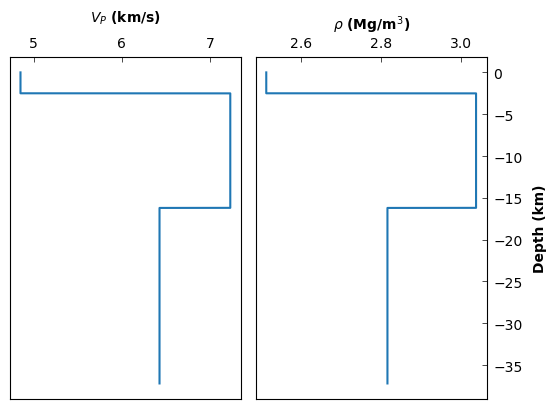

In [4]:
# call density conversion function
# note that using profile_type="Vs" first calls a function to convert to Vp
# as is required by Brocher's (2005) approach.
profile_brocher = convert_V_profile(vp_file, 
                            profile_type="Vp", 
                            approach="brocher",
                            working_file = True)

# Define plot settings
plot_type = 'line'
titles = ['', '']
xlabels = [r'${V_P}$ (km/s)', r'$\rho$ (Mg/m${^3}$)']
ylabels = ['Depth (km)', 'Depth (km)']
n_panels = 2

# data1 and data2 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile_brocher["Vp"][:,1], 'y': profile_brocher["Vp"][:,0]}]
data2 = [{'x': profile_brocher["rho"][:,1], 'y': profile_brocher["rho"][:,0]}]

# Call the plot_panels function
plot_panels([data1, data2], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=0.7, 
            save_path=None)

### Stephenson et al. (2023) conversion scheme

Now let's calculate density using the `stephenson` approach that is the focus of this work, looking at the effects of using different options.  We will compare to the `brocher` method.

We will need to load in the parameter files first.  These parameters have been fitted to laboratory data following the approach laid out in Stephenson et al. (2023).

The panels below show the following:
>1. The seismic velocity profile.
>2. The `brocher` density profiles and the high-resolution `stephenson` density profile
>3. The `brocher` density profiles and the `stephenson` density profile binned into the same depth ranges as the original velocity profile



In [6]:
#density conversion approach
approach = "stephenson"
#approach = "brocher"

# do you want to use full T and P dependent conversion?
T_dependence = True

# directory containing parameter files
parameter_dir = "../CONVERSION_PARAMETERS"

# path to density conversion parameters (if using stephenson approach)
Vp_parameter_file = parameter_dir + "/Vp_parameters.dat"
Vs_parameter_file = parameter_dir + "/Vs_parameters.dat"

# depth and density values for constant density for uppermost part of crust
#   Prevents spurious densities in the exponential part
#   of the relationship since this exponential dropoff is
#   rarely honoured in the seismic data.
#    NB. ONLY APPLICABLE IF USING approach = "stephenson"

rho_const = 2.75        # constant density of uppermost crust Mg/m^3
d_const = 7.            # depth range for constant density, km


In [7]:
# load parameter files for density conversion
Vp_params = np.loadtxt(Vp_parameter_file)
Vs_params = np.loadtxt(Vs_parameter_file)

# make parameters variable to pass to conversion function
parameters = np.column_stack((Vp_params, Vs_params))

# first we will convert to density without accounting for temperature or compressibility
profile_stephenson_no_T = convert_V_profile(vp_file, 
                            profile_type="Vp", 
                            approach="stephenson",
                            parameters=parameters[:,0],
                            working_file = True)

print("\n")
print("List of fields in dictionary object generated by conversion scheme... \n")
for key in profile_stephenson_no_T.keys():
    print(key)


working on ../TEST_DATA/EUROPE/Vp/RECEIVER_FUNCTION/DATA/M19_AQU_Vp.dat


List of fields in dictionary object generated by conversion scheme... 

station
Vp_file
region
moho
location
av_Vp
Vp
type
method
rho
av_rho
rho_hi_res
Vp_hi_res
p


/Users/eart0518/Work/SMV2rho/src/SMV2rho/density_functions.py:1473: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_val = integrate.quad(interp_profile, bins_low_res[e],


Notice that the programme will print the file that is being worked on to the command line.  Also shown iks a list of the keys contained within the output dictionary object.  Most are seelf explanatory.  For example `moho` and `'av_rho` are the crustal thickness and average density (float objects), while `Vp_file` is the file path (string object).  `rho` and `Vp` are the density and velocity profiles (numpy ndarray objects), etc. 

### Keeping upper crustal density constant

Now we can try some different options for the `stephenson` conversion scheme.

Let's try keeping the density of the upper 7 km constant so that we don't map empirical valocity decreases into density increases in the shallow crust.  This option can be useful if the length-scale or amplitude of the velocity dropoff at shallow depths does not accord with that observed in the velocity profile.  This is often the case because local geology dramatically influences the velocity dropoff.  In Stephenson et al. (2023), we choose to keep the upper $7$ km of the crust at a constant density of $2.75$ Mg/m$^3$.

To do this, we set the `constant_depth` and `constant_density` arguments.

In [8]:
# convert to density without accounting for temperature or compressibility
#   keep the upper 7 km constant density 
profile_stephenson_no_T_const7 = convert_V_profile(vp_file, 
                                 profile_type="Vp", 
                                 approach="stephenson",
                                 parameters=parameters[:,0],
                                 constant_density=2.75,
                                 constant_depth=7,
                                 working_file = True)


working on ../TEST_DATA/EUROPE/Vp/RECEIVER_FUNCTION/DATA/M19_AQU_Vp.dat


/Users/eart0518/Work/SMV2rho/src/SMV2rho/density_functions.py:1473: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_val = integrate.quad(interp_profile, bins_low_res[e],


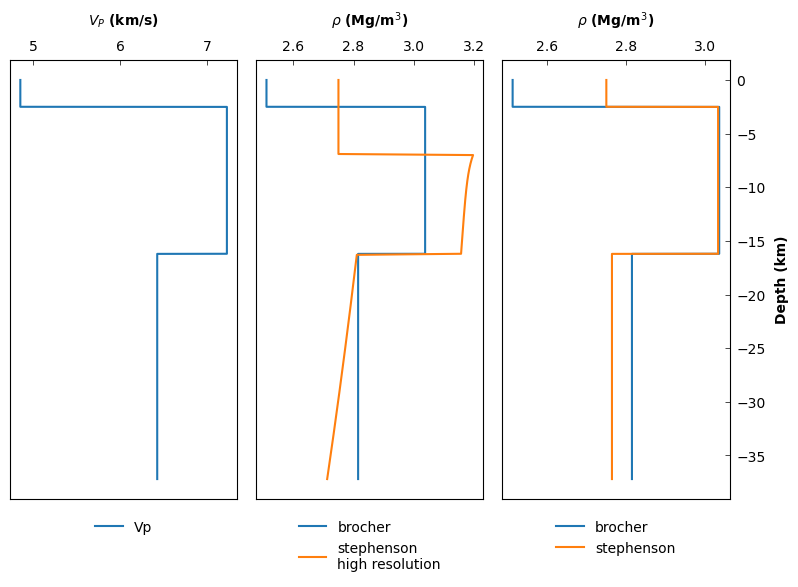

In [9]:
# PLOTTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Define plot settings
plot_type = 'line'
titles = ['', '', '']
xlabels = [r'${V_P}$ (km/s)', r'$\rho$ (Mg/m${^3}$)', r'$\rho$ (Mg/m${^3}$)']
ylabels = ['Depth (km)', 'Depth (km)', 'Depth (km)']
n_panels = 2

# data1 -- Vp profile
data1 = [{'x': profile_stephenson_no_T_const7["Vp"][:,1], 
          'y': profile_stephenson_no_T_const7["Vp"][:,0],
          'label': "Vp"}]

# data2 -- brocher density and the high-resolution density stephenson profile
data2 = [{'x': profile_brocher["rho"][:,1], 'y': 
          profile_brocher["rho"][:,0], 'label': 'brocher'},
         {'x': profile_stephenson_no_T_const7["rho_hi_res"][:,1], 
          'y': profile_stephenson_no_T_const7["rho_hi_res"][:,0], 
               'label': "stephenson\nhigh resolution"}]

# data3 -- brocher density and the stephenson density profile binned into same 
#   resolution as velocity profile
data3 = [{'x': profile_brocher["rho"][:,1], 'y': 
          profile_brocher["rho"][:,0], 'label': 'brocher'},
         {'x': profile_stephenson_no_T_const7["rho"][:,1], 
          'y': profile_stephenson_no_T_const7["rho"][:,0], 
                'label': "stephenson"}]

# Call the plot_panels function
plot_panels([data1, data2, data3], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=1.0, 
            save_path=None)

The `high resolution` curve is the curve actually used to calculate density.  This profile is calculated by discretising the velocity profile and then calculating density at each depth, integrating pressure downwards as we go.  It is possible to see the resultant pressure profile by the plotting the `'p'` profile in the data dictionary.  Try the following...

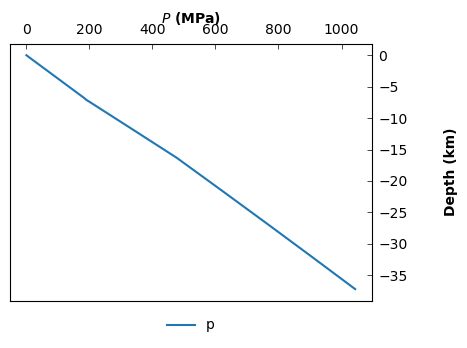

In [10]:
# data1 -- Vp profile
data1 = [{'x': profile_stephenson_no_T_const7["p"][:,1], 
          'y': profile_stephenson_no_T_const7["p"][:,0],
          'label': "p"}]

xlabels = [r'$P$ (MPa)']

# Call the plot_panels function
plot_panels([data1], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=0.6, 
            save_path=None)

### Including temperature and pressure dependence

This time, we will correct velocity and density for temperature and pressure dependence.  This means accounting for the elastic effect of temperature upon seismic velocity, but also the effects of thermal expansion and compressibility upon density. First we must read in a T-dependent parameter file.

working on ../TEST_DATA/EUROPE/Vp/RECEIVER_FUNCTION/DATA/M19_AQU_Vp.dat


List of fields in dictionary object generated by conversion scheme... 

station
Vp_file
region
moho
location
av_Vp
Vp
type
method
rho
av_rho
rho_hi_res
Vp_hi_res
p
T


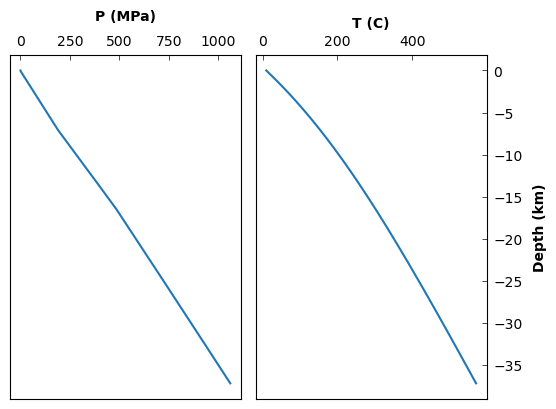

In [11]:
# load parameters for temperature dependence
# T parameters file has following structure...
#   [dVpdT, dVsdT, alpha0, alpha1, K]
T_parameters = np.loadtxt(parameter_dir + "/T_parameters.dat")

# get the relevant parameters for Vp profiles
# when converting a single profile we must take [dVpdT, alpha0, alpha1, K]
T_parameters_Vp = [T_parameters[0], T_parameters[2], T_parameters[3],
                  T_parameters[4]]

# convert to density accounting for temperature or compressibility
#   keep the upper 7 km constant density 
profile_stephenson_no_T_const7_T = convert_V_profile(vp_file, 
                                   profile_type = "Vp", 
                                   approach = "stephenson",
                                   parameters = parameters[:,0],
                                   constant_density = 2.75,
                                   constant_depth = 7,
                                   T_parameters = T_parameters_Vp,
                                   T_dependence = True,
                                   working_file = True)

# PLOTTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Define plot settings
plot_type = 'line'
titles = ['', '', '']
xlabels = [r'P (MPa)', r'T (C)']
ylabels = ['Depth (km)', 'Depth (km)']
n_panels = 2

print("\n")
print("List of fields in dictionary object generated by conversion scheme... \n")
for key in profile_stephenson_no_T_const7_T.keys():
    print(key)

# Let's plot up the temperature and pressure ~profiles
data1 = [{'x': profile_stephenson_no_T_const7_T["p"][:,1], 
          'y': profile_stephenson_no_T_const7_T["p"][:,0]}]
data2 = [{'x': profile_stephenson_no_T_const7_T["T"][:,1], 
          'y': profile_stephenson_no_T_const7_T["T"][:,0]}]

# Call the plot_panels function
plot_panels([data1, data2], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=0.7, 
            save_path=None)

Notice there is now a `'T'` field in the dictionary.

Now let's plot up the velocity profiles keeping track of how the density profiles change as we include more sophisticated parametrisations.

We can see from the plots below that different factors have different ecctes over different depth ranges.  For this particular velocity profile, we see that `brocher` does a decent job ad mid crustal depths, but dramatically undershoots at mid-crustal depths.  Similarly, in this case, including the elastic and thermal expansion effects of $T$ on $V$ and $\rho$ doesn't have much effect overall.  This is because both compressibility and $V(T)$ are broadly cancelled out by the effect of thermal expansion.

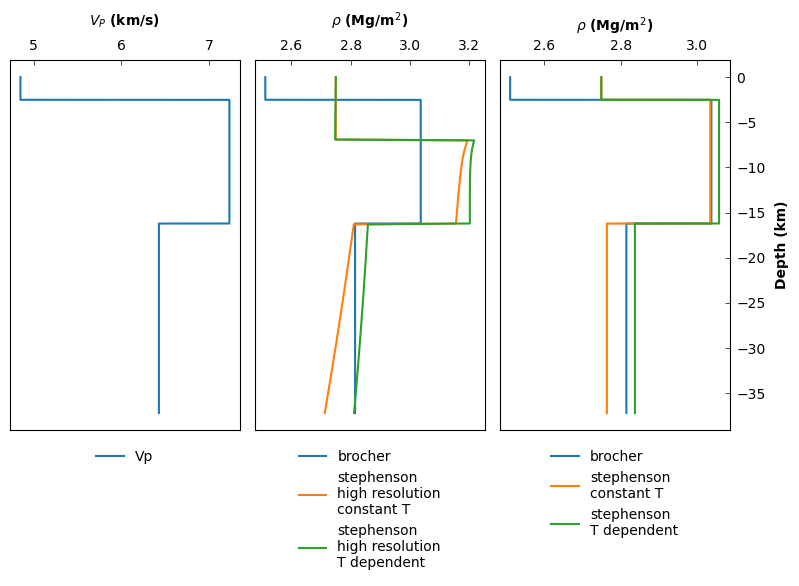

In [12]:
# PLOTTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Define plot settings
plot_type = 'line'
titles = ['', '', '']
xlabels = [r'${V_P}$ (km/s)', r'$\rho$ (Mg/m${^2}$)', r'$\rho$ (Mg/m${^2}$)']
ylabels = ['Depth (km)', 'Depth (km)', 'Depth (km)']
n_panels = 2

# data1 -- Vp profile
data1 = [{'x': profile_stephenson_no_T_const7_T["Vp"][:,1], 
          'y': profile_stephenson_no_T_const7_T["Vp"][:,0],
          'label': "Vp"}]

# data2 -- brocher density and the high-resolution density stephenson profile
data2 = [{'x': profile_brocher["rho"][:,1], 'y': 
          profile_brocher["rho"][:,0], 'label': 'brocher'},
         {'x': profile_stephenson_no_T_const7["rho_hi_res"][:,1], 
          'y': profile_stephenson_no_T_const7["rho_hi_res"][:,0], 
               'label': "stephenson\nhigh resolution\nconstant T"}, 
         {'x': profile_stephenson_no_T_const7_T["rho_hi_res"][:,1], 
          'y': profile_stephenson_no_T_const7_T["rho_hi_res"][:,0], 
               'label': "stephenson\nhigh resolution\nT dependent"}]

# data3 -- brocher density and the stephenson density profile binned into same 
#   resolution as velocity profile
data3 = [{'x': profile_brocher["rho"][:,1], 'y': 
          profile_brocher["rho"][:,0], 'label': 'brocher'},
         {'x': profile_stephenson_no_T_const7["rho"][:,1], 
          'y': profile_stephenson_no_T_const7["rho"][:,0], 
                'label': "stephenson\nconstant T"}, 
         {'x': profile_stephenson_no_T_const7_T["rho"][:,1], 
          'y': profile_stephenson_no_T_const7_T["rho"][:,0], 
                'label': "stephenson\nT dependent"}]

# Call the plot_panels function
plot_panels([data1, data2, data3], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=1.0, 
            save_path=None)

### Uncertainty propagation

Let's explore the uncertainties in the density conversion using the `uncertainties` module.  We will estimate uncertainty as a function of depth within the crust for crust with $t_c = 40$ km and $\overline{\rho}_c = 2.90$ Mg m$^{-3}$.

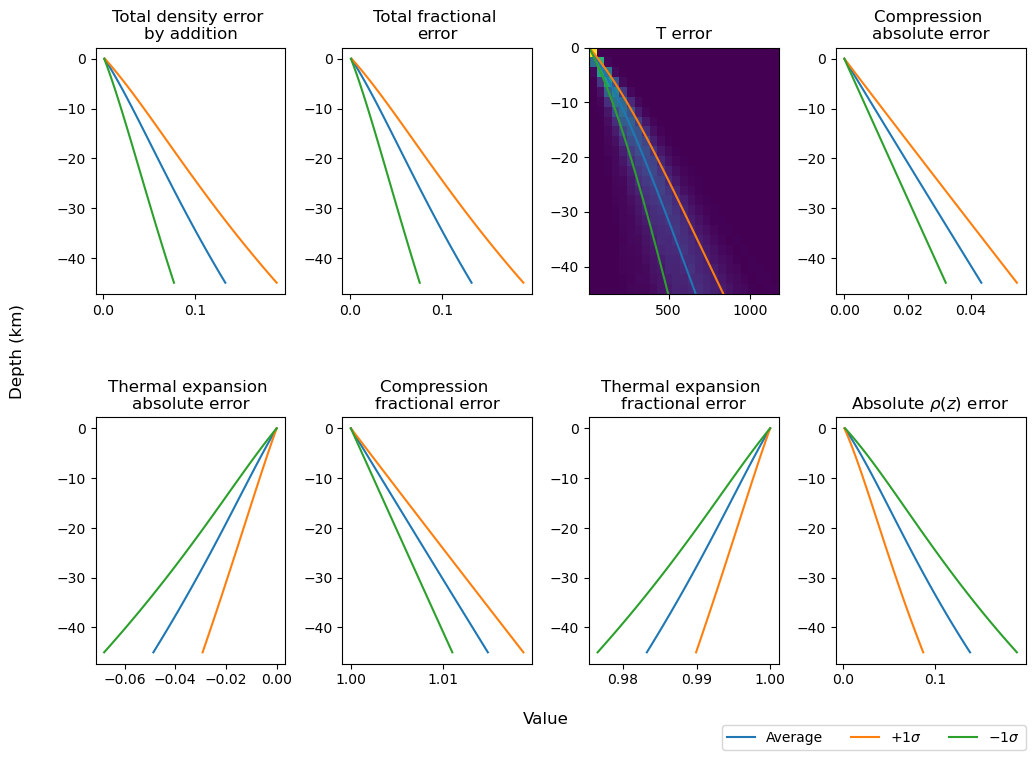

bulk crustal density error = 0.091 Mg m³
[-4.0e-04 -2.3e-04  1.0e-05  2.9e-08  9.0e+10]


In [15]:
from SMV2rho.uncertainties import *

# heatflow parameter values
q0 = 59e-3
qm = 30e-3
hr = 10
dvdT = 4e-4  # velocity temperature derivative

# heatflow parameter uncertainties
dq0 = 14e-3
dqm = 10e-3
dhr = 5
ddvdT = 1e-4

# thermal expansion and bulk modulus (CRUST)
alpha0 = 1e-5
alpha1 = 2.5e-8
K = 90e9

# thermal expansion and bulk modulus uncertainties (CRUST)
dalpha0 = 0.5e-5
dalpha1 = 0.5e-8
dK = 20e9

# error in density conversion calculation
dens_conv_err = 0.11

# example crustal thickness and density
tc = 45
rho_c = 2.9

sigma = rho_err(tc, rho_c, q0, dq0, qm, dqm, hr, dhr, dvdT, ddvdT, 
                alpha0, dalpha0, alpha1, dalpha1, K, dK, 
                Vp_parameter_file, N=1000, z_slices=100, 
                make_plots=True, save_plots=False, outpath=None)

print(f"bulk crustal density error = {2.9*sigma[0]:.3f} Mg m\u00b3")

print(T_parameters)

We can see how uncertainties in all parameters grow as we move deeper into the crust.  In the plots above, absolute error represents uncertainties in absolute value of density as a function of uncertaintiy in the given process (e.g. velocity-to-density conversion, compression, thermal expansion).  Fractional error represents the proportional change in density as a function of the given process.  You can play with the mean and uncertainty values above and see how uncertainty estimates change.

### Converting multiple velocity profiles to density

It is likely that we will want to convert many velocity profiles to density.  For example, if we have an ambient noise tomographic model, we will need to convert multiple depth slices to velocity.  The simplest way to achieve this is to convert our model into many individual vertical profiles.  This is more straightforward since we must calculate pressure downwards through each profile.

Please note that at this point the strict file system described at the start becomes very important!  We will use the `path` variable to point towards the full data directory.

We convert multiple profiles simulatneously using the `run_convert_velocities` function.  We will use this function to return a `station_profiles` oject, which is a list of dictionaries that we have been inspecting previously.  To start with we will not write out any data (`write_data = 'no'`).

We can set the `which_profiles` parameter to only select a specific region.  For example, if we set this to `AUSTRALIA` and we had a database of australian profiles, it would select only those data.  We will convert all profiles.  This will take about 5 minutes to run on a 2021 macbook pro.  We will set `parallel` to `False` because parallel computing it is not guaranteed to work on all ines.

NB., when we are converting ALL profiles together, we pass a parameters file with two columns for Vp and Vs in first and second columns.  Similarly, the T_parameters file must contain [dVpdT, dVsdT, alpha0, alpha1, K]

First we need to access the repository on Zenodo.  Download the data in the `seisCRUST` repository: `https://doi.org/10.5281/zenodo.10017429`.

Set the master directory `CRUSTAL_STRUCTURE` as the `path` variable.

In [18]:
path = "../../SEISCRUST_WORKING/CRUSTAL_STRUCTURE" # path to the full velocity profile directory

which_profiles = 'ALL' # convert all profiles

# set up the class instance to convert multiple profiles at once
Profiles = MultiConversion(path, 
                        which_location = which_profiles,
                        write_data = False, 
                        approach = "stephenson",
                        parameters = parameters,
                        constant_depth = 7,
                        constant_density = 2.75,
                        T_dependence = True,
                        T_parameters = T_parameters)

# assemble necessary information to carry out conversion
#  e.g. file paths, parameters, other metadata etc.
Profiles.assemble_file_lists()

# run density conversion for all profiles
station_profiles = Profiles.send_to_conversion_function()


ALL selected, assembling file lists for all profiles...
   -- assembling lists for WEST_TIBET
   -- assembling lists for N_ATLANTIC
   -- assembling lists for HUDSON_BAY
   -- assembling lists for SE_ASIA
   -- assembling lists for N_AFRICA
   -- assembling lists for ARABIA
   -- assembling lists for TIEN_SHAN
   -- assembling lists for CARIBBEAN
   -- assembling lists for USGS_GSC
   -- assembling lists for EUROPE
   -- assembling lists for INDIA
   -- assembling lists for S_AFRICA
   -- assembling lists for MADAGASCAR
   -- assembling lists for IRAN
   -- assembling lists for S_AMERICA
Reading in data and converting to density using stephenson approach...
[==================================================] 100%

### Locating coincident profiles

We can now locate profiles that occur in roughly the same location, using a particular buffer distance `buff`, which determines how close two profiles need to be to one another to be accepted.  Doing this filtering will allow us to plot up $V_p$ and $V_s$ against each other and to inspect whether the density conversion scheme is behaving as expected.

We will select any $V_S$ profile that occurs in the same location as a $V_P$ profile to see how the density conversion is performing.

Running this programme will take probably about 30 seconds for the whole database.

In [19]:
buff = 50 # buffer distance to nearest profile

# extract vs profiles and vp profiles from station_profiles
vs_profiles = np.array(list(filter(lambda station: 
                            station['type'] == 'Vs', station_profiles)))
vp_profiles = np.array(list(filter(lambda station: 
                            station['type'] == 'Vp', station_profiles)))

# calculate coincident vp and vs profiles within buffer distance, buff
coincident_profiles, vp_profiles, vs_profiles = get_coincident_profiles(vp_profiles, vs_profiles, buff)

# get some bulk crustal properties for the coincident profiles,
#  e.g. compare densities or moho depth etc.
# also return the location of coincident profiles.
vp_vs_vpcalc, rho_rho, moho_moho, lon_lat = \
    compare_adjacent_profiles(vp_profiles, coincident_profiles, approach)

Finding stations with coincident Vp and Vs surveys...
   -- this may take a few minutes...!
   -- taking locations < 50.0 km from vp measurement
       - currently on item 100 of 2431
       - currently on item 200 of 2431
       - currently on item 300 of 2431
       - currently on item 400 of 2431
       - currently on item 500 of 2431
       - currently on item 600 of 2431
       - currently on item 700 of 2431
       - currently on item 800 of 2431
       - currently on item 900 of 2431
       - currently on item 1000 of 2431
       - currently on item 1100 of 2431
       - currently on item 1200 of 2431
       - currently on item 1300 of 2431
       - currently on item 1400 of 2431
       - currently on item 1500 of 2431
       - currently on item 1600 of 2431
       - currently on item 1700 of 2431
       - currently on item 1800 of 2431
       - currently on item 1900 of 2431
       - currently on item 2000 of 2431
       - currently on item 2100 of 2431
       - currently on it

We can now plot up the locations of these coincident profiles.  This routine will require `cartopy` to be installed.

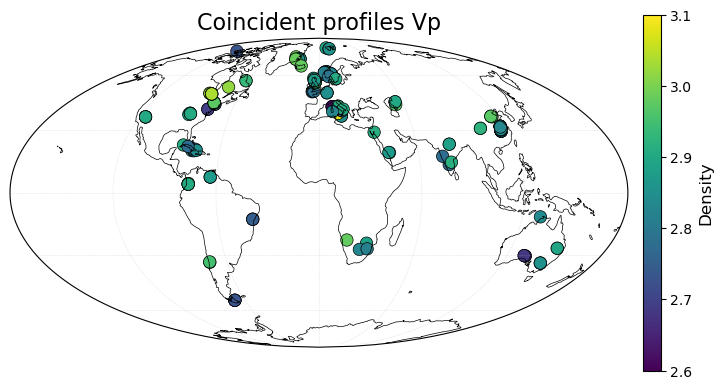

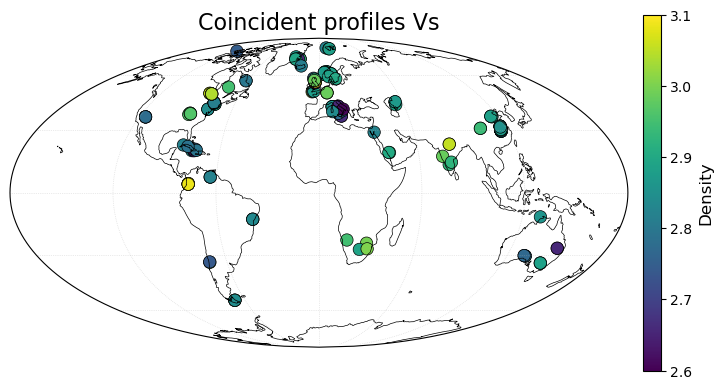

In [20]:
# Locations of coincident profiles (Vp density)
lon, lat = lon_lat[:,0], lon_lat[:,1]
color = rho_rho[:,0]

plot_geographic_locations(lon, lat, color, projection='Mollweide', 
                         title='Coincident profiles Vp', 
                         third_field_label='Density',
                         colorbar_range=[2.6, 3.1])

# Locations of coincident profiles (Vs density)
color = rho_rho[:,1]
plot_geographic_locations(lon, lat, color, projection='Mollweide', 
                         title='Coincident profiles Vs', 
                         third_field_label='Density',
                         colorbar_range=[2.6, 3.1])


We can see that the $V_s$ approach yields a somehat lower density than the $V_p$ approach.  This is likely to be related to the value of $\frac{\partial V_s}{\partial T}$ used.  Currently the same value for $V_P$ and $V_S$ is used, but this results in a greater correction being applied for $V_S$ than for $V_P$.  This will be the subject of future work.

Let's plot some scatter plots to investigate the relationships between the calculated and observed parameters for $V_S$ and $V_P$ observations.  We will plot a regression excluding clear outliers based on a z-score criterion (i.e. distance of a given point from the mean of a distribution).  We will use an unbiased regression that ssumes errors are in both $x$ and $y$ and exclude outliers.

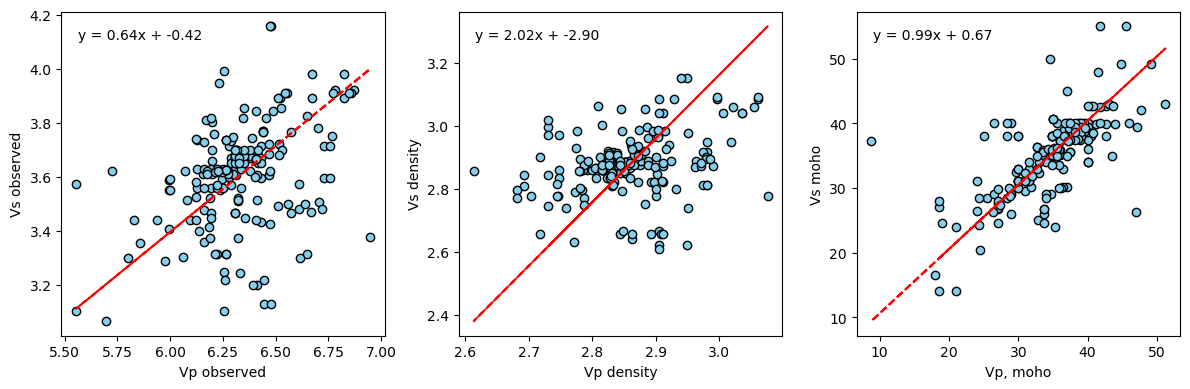

In [21]:
plot_three_scatter(vp_vs_vpcalc[:, :2], 
                   rho_rho, moho_moho, 
                   x_labels=["Vp observed", "Vp density", "Vp, moho"], 
                   y_labels=["Vs observed", "Vs density", "Vs moho"])

The blue lines are the 1:1 relationship and the red lines are the best-fitting regression (excluding the clear outlier).  We can see that we are doing a decent job of getting results that are in broad agreement.

### Average and bulk density

Finally, we will calculate an average density and velocity relationship through the crust based on all of our data that we calculated in `station_profiles`.  We will use the `av_profile` function to do this.  This function interpolates each profiles and calculates an arithemtic mean and median at each depth interval.

In [22]:
# get average density as function of depth and bulk density as function of crustal thickness
# rho_z, rho_tc etc are functions describing depth-wise average velocity and density, and
# bulk velocity and density.

print("Getting average density, Vp and Vs profiles")
rho_z, rho_tc = av_profile([profile['rho_hi_res'] 
                             for profile in station_profiles], 70)
Vp_z, Vp_tc = av_profile([profile['Vp_hi_res'] 
                          for profile in station_profiles if 'Vp' in profile], 70)
Vs_z, Vs_tc = av_profile([profile['Vs_hi_res'] 
                          for profile in station_profiles if 'Vs' in profile], 70)


Getting average density, Vp and Vs profiles


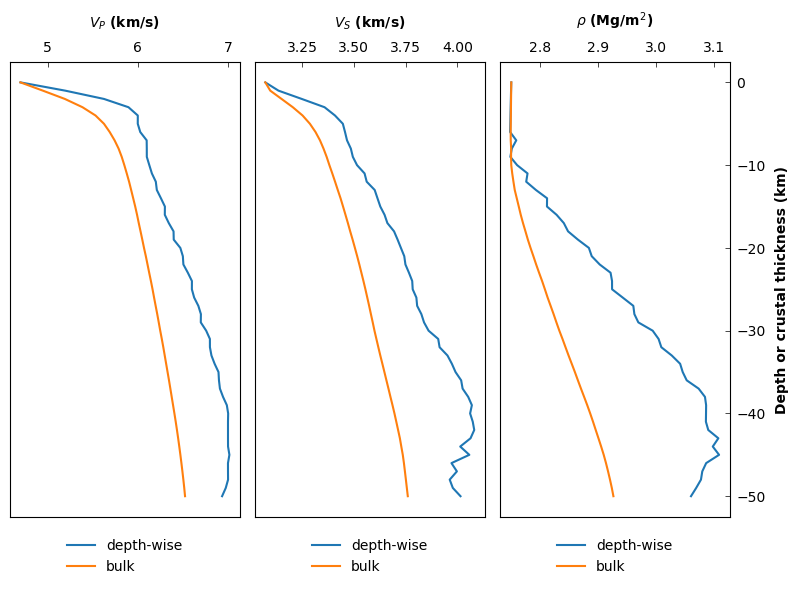

In [23]:
# plot up v(z) and v(t_c) profiles and rho(z) and rho(t_c) profiles

# Define plot settings
plot_type = 'line'
titles = ['', '', '']
xlabels = [r'${V_P}$ (km/s)', 
           r'${V_S}$ (km/s)', 
           r'$\rho$ (Mg/m${^2}$)']
ylabels = ['Depth or crustal thickness (km)', 
           'Depth or crustal thickness (km)', 
           'Depth or crustal thickness (km)']
n_panels = 2

z = np.linspace(0, 50, 51)

# data1 -- Vp
data1 = [{'y': -z, 
          'x': Vp_z(z),
          'label': "depth-wise"},
         {'y': -z, 
          'x': Vp_tc(z),
          'label': "bulk"}]

# data2 -- Vs
data2 = [{'y': -z, 
          'x': Vs_z(z),
          'label': "depth-wise"},
         {'y': -z, 
          'x': Vs_tc(z),
          'label': "bulk"}]

# data3 -- rho
data3 = [{'y': -z, 
          'x': rho_z(z),
          'label': "depth-wise"},
         {'y': -z, 
          'x': rho_tc(z),
          'label': "bulk"}]

# Call the plot_panels function
plot_panels([data1, data2, data3], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=1.0, 
            save_path=None)

### Summary

We have now used various different approaches to convert between velocity and density.  We can see that pressure and temperature are important but that seismic velocity does provide a useful constraint on density that can be estimated.  This tutorial hopefully provides the wherewithal to implement these conversions on any arbitrary data and to inspect the results.

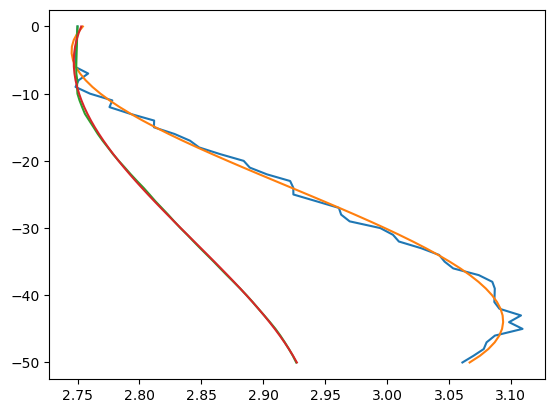

In [24]:
a = np.polyfit(z, rho_z(z), 3)
b = np.polyfit(z, rho_tc(z), 3)

plt.plot(rho_z(z), -z)
plt.plot(np.polyval(a, z), -z)

plt.plot(rho_tc(z), -z)
plt.plot(np.polyval(b, z), -z)